In [1]:
# Light GBM for Avito Demand Prediction Challenge
# Uses Bag-of-Words, meta-text features, and dense features.
# NO COMPUTER VISION COMPONENT.

# https://www.kaggle.com/c/avito-demand-prediction
# By Nick Brooks, April 2018

import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
# print("Data:\n",os.listdir("../input"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("\nData Load Stage")
training = pd.read_csv('../train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv('../test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index
y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))


Data Load Stage
Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns


In [3]:
print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [4]:
print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(-999,inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

Feature Engineering

Create Time Variables


In [5]:
print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))
    
print("\nText Features")

# Feature Engineering 
df['text_feat'] = df.apply(lambda row: ' '.join([
    str(row['param_1']), 
    str(row['param_2']), 
    str(row['param_3'])]),axis=1) # Group Param Features
df.drop(["param_1","param_2","param_3"],axis=1,inplace=True)

# Meta Text Features
textfeats = ["description","text_feat", "title"]
for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('nicapotato') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1']

Text Features


In [6]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}
def get_col(col_name): return lambda x: x[col_name]
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=16000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('text_feat',CountVectorizer(
            ngram_range=(1, 2),
            #max_features=7000,
            preprocessor=get_col('text_feat'))),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])


[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [7]:
start_vect=time.time()
vectorizer.fit(df.loc[traindex,:].to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
df.drop(textfeats, axis=1,inplace=True)

Vectorization Runtime: 10.20 Minutes


In [8]:
# # Dense Features Correlation Matrix
# f, ax = plt.subplots(figsize=[10,7])
# sns.heatmap(pd.concat([df.loc[traindex,[x for x in df.columns if x not in categorical]], y], axis=1).corr(),
#             annot=False, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'},cmap="plasma",ax=ax, linewidths=.5)
# ax.set_title("Dense Features Correlation Matrix")
# plt.savefig('correlation_matrix.png')

In [9]:
print("Modeling Stage")
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

print("\nModeling Stage")

# Training and Validation Set
"""
Using Randomized train/valid split doesn't seem to generalize LB score, so I will try time cutoff
"""
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=1)

Modeling Stage
1503424 Rows and 1186566 Cols
508438 Rows and 1186566 Cols
Feature Names Length:  1186566

Modeling Stage


In [10]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': -1,
    'num_leaves': 37,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.015,
    'verbose': 0,
    'n_jobs' : -1,
    'reg_rambda' :0.5
}  

# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=tfvocab,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=tfvocab,
                categorical_feature = categorical)

# Go Go Go
modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=15000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

Light Gradient Boosting Regressor


/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.226685	valid's rmse: 0.22884
[400]	train's rmse: 0.223131	valid's rmse: 0.226382
[600]	train's rmse: 0.221172	valid's rmse: 0.225153
[800]	train's rmse: 0.21978	valid's rmse: 0.22439
[1000]	train's rmse: 0.218643	valid's rmse: 0.223811
[1200]	train's rmse: 0.217686	valid's rmse: 0.223356
[1400]	train's rmse: 0.216853	valid's rmse: 0.222988
[1600]	train's rmse: 0.216122	valid's rmse: 0.222692
[1800]	train's rmse: 0.215401	valid's rmse: 0.222424
[2000]	train's rmse: 0.214773	valid's rmse: 0.222211
[2200]	train's rmse: 0.214162	valid's rmse: 0.222014
[2400]	train's rmse: 0.213625	valid's rmse: 0.22186
[2600]	train's rmse: 0.213097	valid's rmse: 0.221717
[2800]	train's rmse: 0.212598	valid's rmse: 0.221582
[3000]	train's rmse: 0.21213	valid's rmse: 0.221467
[3200]	train's rmse: 0.211667	valid's rmse: 0.22137
[3400]	train's rmse: 0.211241	valid's rmse: 0.221274
[3600]	train's rmse: 0.210832	valid's rmse: 0.

Text(0.5,1,'Light GBM Feature Importance')

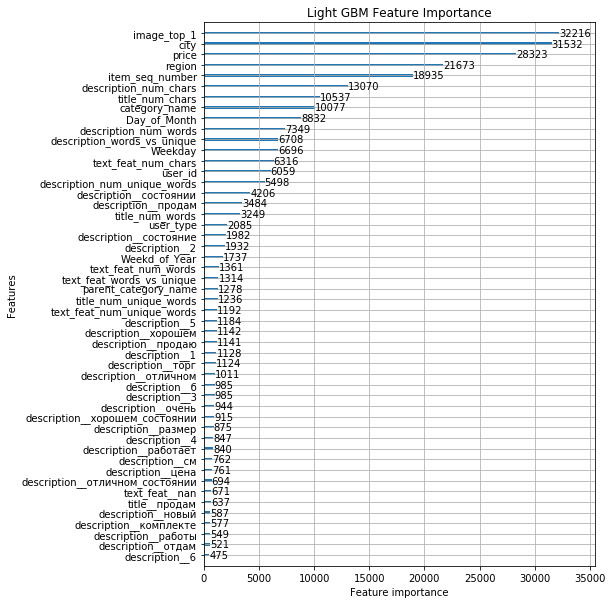

In [13]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [14]:
# print("Model Evaluation Stage")
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Model Runtime: 180.42 Minutes
Notebook Runtime: 193.90 Minutes


In [56]:
! kaggle competitions submit -c avito-demand-prediction -f lgsub.csv -m "Message"

Successfully submitted to Avito Demand Prediction Challenge

In [16]:
gc.collect()

43

# feature selection

In [36]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1353081, 1186566), (150343, 1186566), (1353081,), (150343,))

In [37]:
model = lgb.LGBMRegressor().fit(X_train, y_train)

In [39]:
y_temp = model.predict(X_valid)

In [40]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid))))

RMSE: 0.2287721218248152


In [45]:
from sklearn.feature_selection import SelectFromModel

X_temp = SelectFromModel(model, prefit=True, threshold=1).transform(X)
testing_temp = SelectFromModel(model, prefit=True, threshold=1).transform(testing)
X_temp.shape, y.shape, testing_temp.shape

((1503424, 680), (1503424,), (508438, 680))

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y, test_size=0.20, random_state=1)

In [50]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': -1,
    'num_leaves': 37,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.015,
    'verbose': 0,
    'n_jobs' : -1,
    'reg_rambda' :0.5
}  

# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train)
lgvalid = lgb.Dataset(X_valid, y_valid)

# Go Go Go
modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=16000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

Light Gradient Boosting Regressor
Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.232007	valid's rmse: 0.232149
[400]	train's rmse: 0.228601	valid's rmse: 0.229074
[600]	train's rmse: 0.2269	valid's rmse: 0.227605
[800]	train's rmse: 0.225777	valid's rmse: 0.226669
[1000]	train's rmse: 0.224948	valid's rmse: 0.226021
[1200]	train's rmse: 0.224314	valid's rmse: 0.22558
[1400]	train's rmse: 0.223793	valid's rmse: 0.225265
[1600]	train's rmse: 0.223347	valid's rmse: 0.22503
[1800]	train's rmse: 0.222951	valid's rmse: 0.224844
[2000]	train's rmse: 0.222592	valid's rmse: 0.224689
[2200]	train's rmse: 0.222249	valid's rmse: 0.224557
[2400]	train's rmse: 0.22193	valid's rmse: 0.224443
[2600]	train's rmse: 0.221629	valid's rmse: 0.224344
[2800]	train's rmse: 0.221327	valid's rmse: 0.224247
[3000]	train's rmse: 0.221051	valid's rmse: 0.224174
[3200]	train's rmse: 0.220779	valid's rmse: 0.224103
[3400]	train's rmse: 0.220516	valid's rmse: 0.224029
[3600]	trai

Text(0.5,1,'Light GBM Feature Importance')

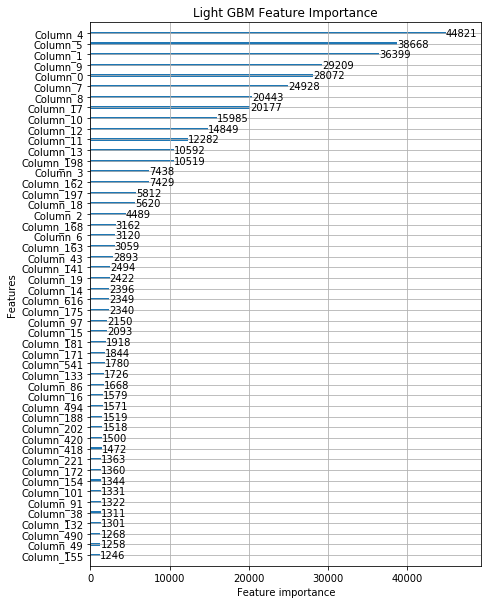

In [51]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [52]:
print("Model Evaluation Stage")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub2.csv",index=True,header=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Model Evaluation Stage
RMSE: 0.22258603486194367


/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Model Runtime: 28.20 Minutes
Notebook Runtime: 249.97 Minutes


In [55]:
! kaggle competitions submit -c avito-demand-prediction -f lgsub2.csv -m "Message"

Successfully submitted to Avito Demand Prediction Challenge